In [6]:
import os
import pickle
#import rpy2.robjects as robjects
import torch
from torch.autograd import Variable
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import scipy.sparse as sp
from torchvision import transforms as tfs
from torch_geometric.data import HeteroData
import torch_geometric.transforms as T
from torch_geometric.nn import HGTConv, Linear
#from torch_geometric.loader import HGTLoader
from torch.cuda.amp import autocast
from torch_geometric.utils import negative_sampling
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc, f1_score, precision_recall_curve, average_precision_score
#from torchsummary import summary
import random
from torch_geometric.nn import RGCNConv
import copy

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(2022)


class RGCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels,num_relations,node_types,init_sizes,num_nodes):
        super(RGCN, self).__init__()
        self.num_nodes=num_nodes
        self.conv1 = RGCNConv(in_channels, hidden_channels,num_relations, num_bases=10)
        self.conv2 = RGCNConv(hidden_channels, out_channels,num_relations, num_bases=10)
        self.lins = torch.nn.ModuleList()
        for i in range(len(node_types)):
            lin = nn.Linear(init_sizes[i], in_channels)
            self.lins.append(lin)
#         self.relu = nn.relu
#         self.lin1 = Linear(out_channels, out_channels)
#         self.lin2 = Linear(out_channels, out_channels)
#         self.dropout = dropout   
    def trans_dimensions(self, g):
        data = copy.deepcopy(g)
        for node_type, lin in zip(node_types, self.lins):
            data[node_type].sim = lin(data[node_type].sim)
        return data
    
    def forward(self, data):
        data = self.trans_dimensions(data)
        homogeneous_data = data.to_homogeneous()
        #print(homogeneous_data)
        edge_index, edge_type = homogeneous_data.edge_index, homogeneous_data.edge_type
        x = self.conv1(homogeneous_data.sim, edge_index, edge_type)
        x = self.conv2(x, edge_index, edge_type)
        xm = x[:self.num_nodes]
        xg = x[self.num_nodes:]
#         xm = self.relu(self.lin1(xm))
#         xg = self.relu(self.lin1(xg))
        return xm,xg

# class RGCN(nn.Module):
#     def __init__(self, in_channels, hidden_channels, out_channels,num_relations,node_types,init_sizes):
#         super(RGCN, self).__init__()
#         #self.num_nodes=num_nodes
#         self.conv1 = RGCNConv(in_channels, hidden_channels,num_relations, num_bases=10)
#         self.conv2 = RGCNConv(hidden_channels, out_channels,num_relations, num_bases=10)
#         self.lins = torch.nn.ModuleList()
#         for i in range(len(node_types)):
#             lin = nn.Linear(init_sizes[i], in_channels)
#             self.lins.append(lin)
#     #         self.relu = nn.relu
#     #         self.lin1 = Linear(out_channels, out_channels)
#     #         self.lin2 = Linear(out_channels, out_channels)
#     #         self.dropout = dropout   
#     def trans_dimensions(self, data):
#         #data = copy.deepcopy(g)
#         for node_type, lin in zip(node_types, self.lins):
#             data[node_type].x = lin(data[node_type].x)
#         return data

#     def forward(self, data):
#         num_nodes = data['miRNA'].num_nodes
#         data = self.trans_dimensions(data)
#         #homogeneous_data = data.to_homogeneous()
#         data = data.to_homogeneous()
#         #print(homogeneous_data)
#         edge_index, edge_type = data.edge_index, data.edge_type
#         x = self.conv1(data.x, edge_index, edge_type)
#         x = self.conv2(x, edge_index, edge_type)
#         xm = x[:num_nodes]
#         xg = x[num_nodes:]
#         #         xm = self.relu(self.lin1(xm))
#         #         xg = self.relu(self.lin1(xg))
#         return xm,xg


class BiLSTM(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, output_size,dropout_rate):
        super(BiLSTM, self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers,bidirectional=True, batch_first=True)
        #insize=64*hidden_size * 2
        self.linear = nn.Linear(64*hidden_size * 2, output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_rate if dropout_rate is not None else 0)

    def forward(self, input):
        """
        input : visual feature [batch_size x T x input_size]
        output : contextual feature [batch_size x T x output_size]
        """
        #self.rnn.flatten_parameters()
        output,(_,_) = self.rnn(input)  # batch_size x T x input_size -> batch_size x T x (2*hidden_size)
        #print(output.size())
        output = output.reshape(len(output), -1)
        #print(output.size())
        output = self.dropout(output)
        output = self.linear(output)  # batch_size x T x output_size
        #print(output.size())
        return output
    
class MLPBilPredictor(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, num_layers, dropout_rate=0.3):
        super(MLPBilPredictor, self).__init__()
        self.lins = torch.nn.ModuleList()
        self.lins.append(torch.nn.Linear(in_channels, hidden_channels))
        for _ in range(num_layers - 1):
            self.lins.append(torch.nn.Linear(hidden_channels, hidden_channels))
        self.bilin = torch.nn.Linear(hidden_channels, hidden_channels, bias=False)
        self.relu = nn.GELU()

    def reset_parameters(self):
        for lin in self.lins:
            lin.reset_parameters()
        self.bilin.reset_parameters()

    def forward(self, x_i, x_j):
        for lin in self.lins:
            x_i, x_j = lin(x_i), lin(x_j)
            x_i, x_j = self.relu(x_i), self.relu(x_j)
        x = torch.sum(self.bilin(x_i) * x_j, dim=-1)
        return x

class RGCN_BiLSTM(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels,num_relations,node_types,init_sizes,num_nodes,\
                 input_size,hidden_size, num_layers,output_size,dropout_rate=0.1):
        super(RGCN_BiLSTM, self).__init__()
        self.rgcn=RGCN(in_channels, hidden_channels,out_channels,num_relations,node_types,init_sizes,num_nodes)
        self.bilstm=BiLSTM(input_size, hidden_size, num_layers, output_size,dropout_rate)

        self.embg = Linear(output_size+out_channels,128,False)
        self.pre=MLPBilPredictor(128, 128, 1, 0.3)
        #self.relu = nn.GELU()
        self.dropout = nn.Dropout(p=dropout_rate if dropout_rate is not None else 0)
    def encoder(self,data,seqG):
        
        xm,xg1=self.rgcn(data)
        #print(xm.size(),xg1.size())
        xg2=self.bilstm(seqG)
        #print(xg2.size())
        xg=self.embg(torch.cat([xg1, xg2], dim=1))
        #print(xg.size())
        xm = self.dropout(xm)
        xg = self.dropout(xg)
        #print(xm.size())
        #print(xg.size())
        return xm,xg
    def decoderMLP(self,xm,xg,edge):
        xm=xm[edge[0]]
        xg=xg[edge[1]]
        #s=self.pre(xm,xg)
        s=torch.sum(xm * xg, dim=-1)
        return s
    def forward(self,data,seqG,label_edge):
        xm,xg=self.encoder(data,seqG)
        s=self.decoderMLP(xm,xg,label_edge)
        return s

class FocalLoss(nn.Module):
    def __init__(self,alpha=0.25,gamma=2.0,reduce='mean'):
        super(FocalLoss,self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduce = reduce
    def forward(self,classifications,targets):
        # classifcation:[N,K]
        # targets: [N,K]的one-hot编码
        alpha = self.alpha
        gamma = self.gamma
        # classifications = classifications.view(-1)  # 不经过sigmoid的classification；
        # targets = targets.view(-1)                  # 应该是 one-hot
        # ce_loss: 对应公式中 -log(pt),也就是普通的 交叉熵损失；--> 该函数接收未经sigmoid的函数；
        ce_loss = F.binary_cross_entropy_with_logits(classifications, targets, reduction="none")
        #focal loss
        p = torch.sigmoid(classifications)                # 经过sigmoid
        p_t = p * targets + (1 - p) * (1 - targets)       #  计算pt
        loss = ce_loss * ((1 - p_t) ** gamma)             # -log(pt) * (1-pt) ** ganmma
        if alpha >= 0:
            # 对应公式中alpha_t控制损失的权重
            alpha_t = alpha * targets + (1 - alpha) * (1 - targets) # 和pt求解过程一样
            loss = alpha_t * loss                         # 最终focal loss
        if self.reduce=='sum':
            loss = loss.sum()
        elif self.reduce=='mean':
            loss = loss.mean()
        else:
            raise ValueError('reduce type is wrong!')
        return loss

def trainAll(model,train_data,seqG,lossF):
    model.train() 
    out = model(train_data,seqG,train_data['regulate'].edge_label_index)
    out=out.view(-1)
    rel=train_data['regulate'].edge_label
    #loss = F.binary_cross_entropy_with_logits(out,rel)
    loss=lossF(out,rel)
    pre=torch.sigmoid(out)
    assert torch.isnan(loss).sum() == 0, print(loss)
    auc=roc_auc_score(rel.detach().numpy(), pre.detach().numpy())
    aupr= average_precision_score(rel.detach().numpy(), pre.detach().numpy())
    #     out = model(train_data.x_dict,train_data.edge_index_dict)
    #     pre=out[train_data['regulate'].edge_label_index[0],train_data['regulate'].edge_label_index[1]]
    #     rel=train_data['regulate'].edge_label
    #     loss = F.binary_cross_entropy_with_logits(pre,rel)
    #     pre=torch.sigmoid(pre)
    #     assert torch.isnan(loss).sum() == 0, print(loss)
    #     auc=roc_auc_score(rel.detach().numpy(), pre.detach().numpy())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return (loss.item(),auc,aupr)

def evaluateAll(model,dat,seqG,lossF):
    model.eval()
    valloss=0
    valauc=0
    with torch.no_grad():
        out = model(dat,seqG,dat['regulate'].edge_label_index)
        out=out.view(-1)
        rel=dat['regulate'].edge_label
        #loss = F.binary_cross_entropy_with_logits(out,rel)
        loss=lossF(out,rel)
        pre=torch.sigmoid(out)
        #         out = model(dat.x_dict,dat.edge_index_dict)
        #         pre=out[dat['regulate'].edge_label_index[0],dat['regulate'].edge_label_index[1]]
        #         rel=dat['regulate'].edge_label
        #         loss = F.binary_cross_entropy_with_logits(pre,rel)
        #         pre=torch.sigmoid(pre)
        auc=roc_auc_score(rel.detach().numpy(), pre.detach().numpy())
        aupr= average_precision_score(rel.detach().numpy(), pre.detach().numpy())
    return (loss.item(),auc,aupr)

class EarlyStopping():
    def __init__(self, tolerance=50, min_delta=0.1):
        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False
    def __call__(self, val_best_auc, val_auc):
        if val_auc<val_best_auc:
            self.counter +=1
            if self.counter >= self.tolerance:
                self.early_stop = True

def transfer_model(pretrained_file, model):
    pretrained_dict = torch.load(pretrained_file,map_location=torch.device('cpu'))  # get pretrained dict
    model_dict = model.state_dict()  # get model dict
    pretrained_dict = transfer_state_dict(pretrained_dict, model_dict)
    model_dict.update(pretrained_dict)
    model.load_state_dict(model_dict)
    return model

def transfer_state_dict(pretrained_dict, model_dict):
    state_dict = {}
    for k, v in pretrained_dict.items():
        if k in model_dict.keys():
            state_dict[k] = v
        else:
            print("Missing key(s) in state_dict :{}".format(k))
    return state_dict

# if __name__ == '__main__':

#     with open('dataCombine_negall_usingmiRNAanchor.pkl','rb') as f:  # Python 3: open(..., 'rb')
#         train_data,val_data,test_data,m,g = pickle.load(f)

#     train_data ['miRNA'].sim = train_data ['miRNA'].mm + train_data ['miRNA'].x
#     val_data ['miRNA'].sim = train_data ['miRNA'].mm + train_data ['miRNA'].x
#     test_data ['miRNA'].sim = train_data ['miRNA'].mm + train_data ['miRNA'].x
#     train_data ['gene'].sim = train_data ['gene'].gg + train_data ['gene'].x
#     val_data ['gene'].sim = train_data ['gene'].gg + train_data ['gene'].x
#     test_data ['gene'].sim = train_data ['gene'].gg + train_data ['gene'].x
    
#     node_types, edge_types = train_data.metadata()
#     num_relations = len(edge_types)
#     init_sizes = [train_data[x].x.shape[1] for x in node_types]
#     num_nodes = train_data['miRNA'].x.shape[0]
    
#     print(num_nodes)
#     seqG=np.load('geneseqkmer.npy')
#     seqG=torch.from_numpy(seqG)
#     seqG=seqG.float()
#     #print(seqG.size())
    
#     model = RGCN_BiLSTM(in_channels=1024, hidden_channels=256, out_channels=128,\
#                         num_relations=num_relations,node_types=node_types,init_sizes=init_sizes,num_nodes=num_nodes,\
#                         input_size=100, hidden_size=64, num_layers=2,output_size=128,dropout_rate=0.1)

#     print(model)

#     for m in model.modules():
#         if isinstance(m, (torch.nn.Linear, torch.nn.Conv1d, torch.nn.Conv2d)):
#             torch.nn.init.xavier_normal_(m.weight)
#     #weight_decay=5e-4
#     optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=5e-3)
#     scaler = torch.cuda.amp.GradScaler(enabled=True)
#     #0.1 0.05 0.01 0.005 0.0001
#     #scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 100, eta_min=0.000001)
#     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max',factor=0.5,verbose=1,min_lr=0.000001,patience=20)
#     lossF=FocalLoss(alpha=0.65, gamma=2,reduce='mean')
#     #lossF=FocalLoss(alpha=-1, gamma=0.2,reduce='mean')
#     #lossF=BCEFocalLoss(gamma=1, alpha=0.75, reduction='elementwise_mean')
#     early_stopping = EarlyStopping(tolerance=20, min_delta=0.15)

#     # Define the early stopping parameters
#     patience = 50
#     #best_va = float('inf')
#     counter = 0
    
#     import time
#     best_val_auc= best_val_aupr= 0
#     best_epoch=-1
#     trainloss=[]
#     valloss=[]
#     valauc=[]
#     trainauc=[]
#     valaupr=[]
#     trainaupr=[]
#     lrchange=[]
#     for epoch in range(1, 1001):
#         since = time.time()
#         print('{} optim: {}'.format(epoch, optimizer.param_groups[0]['lr']))
#         lrchange.append(optimizer.param_groups[0]['lr'])
#         train_loss,train_auc,train_aupr = trainAll(model,train_data,seqG,lossF)
#         trainloss.append(train_loss)
#         print('train_loss:',train_loss)
#         #time_elapsed = time.time() - since
#         #print('Training in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
#         #since1 = time.time()
#         val_loss,val_auc,val_aupr = evaluateAll(model,val_data,seqG,lossF)
#         valauc.append(val_auc)
#         valloss.append(val_loss)
#         trainauc.append(train_auc)
#         valaupr.append(val_aupr)
#         trainaupr.append(train_aupr)
#         #time_elapsed = time.time() - since1
#         #print('Val and Testing in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
#         #scheduler.step() 
#         scheduler.step(val_aupr)
#         if val_aupr > best_val_aupr:
#             best_val_auc = val_auc
#             best_val_aupr=val_aupr
#             counter = 0
#             best_epoch = epoch
#             #print(f'best aupr {epoch}')
#             torch.save(model, './RGCN_BiLSTM/RGCN_BiLSTMbest_cpu_directDot_usingmiRNAanchor.pt')
#             time_elapsed = time.time() - since
#             log = 'Epoch: {:03d}, Epoch complete in {:.0f}m {:.0f}s, trainLoss: {:.4f}, Valloss: {:.4f}, Trainauc: {:.4f}, Valauc: {:.4f}, Valbestauc: {:.4f},Trainaupr: {:.4f}, Valaupr: {:.4f}, Valbestaupr: {:.4f}'
#             print(log.format(epoch, time_elapsed // 60, time_elapsed % 60,train_loss, val_loss,train_auc,val_auc,best_val_auc,train_aupr,val_aupr,best_val_aupr))
#         else:
#             counter += 1
#             time_elapsed = time.time() - since
#             log = 'Epoch: {:03d}, Epoch complete in {:.0f}m {:.0f}s, trainLoss: {:.4f}, Valloss: {:.4f}, Trainauc: {:.4f}, Valauc: {:.4f}, Valbestauc: {:.4f},Trainaupr: {:.4f}, Valaupr: {:.4f}, Valbestaupr: {:.4f}'
#             print(log.format(epoch, time_elapsed // 60, time_elapsed % 60,train_loss, val_loss,train_auc,val_auc,best_val_auc,train_aupr,val_aupr,best_val_aupr))
#             if counter >= patience:
#                 print(f'Early stopping at epoch {epoch}')
#                 print(f'best aupr at epoch {best_epoch}')
#                 break
        
#         # if val_aupr > best_val_aupr:
#         #     best_val_auc = val_auc
#         #     best_val_aupr=val_aupr
#         #     torch.save(model, 'RGCN_BiLSTMbest.pt')
#         # #    test_auc= tmp_test_auc
#         # #scheduler.step()
#         # time_elapsed = time.time() - since
#         # log = 'Epoch: {:03d}, Epoch complete in {:.0f}m {:.0f}s, trainLoss: {:.4f}, Valloss: {:.4f}, Trainauc: {:.4f}, Valauc: {:.4f}, Valbestauc: {:.4f},Trainaupr: {:.4f}, Valaupr: {:.4f}, Valbestaupr: {:.4f}'
#         # print(log.format(epoch, time_elapsed // 60, time_elapsed % 60,train_loss, val_loss,train_auc,val_auc,best_val_auc,train_aupr,val_aupr,best_val_aupr))


#     with open('./RGCN_BiLSTM/RGCN_BiLSTMResult_cpu_directDot_usingmiRNAanchor.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
#         pickle.dump([trainloss, trainauc,trainaupr,valloss,valauc,valaupr,lrchange], f)

#     torch.save(model, './RGCN_BiLSTM/RGCN_BiLSTM_cpu_directDot_usingmiRNAanchor.pt')###24mc

In [7]:
torch.cuda.set_device(0)
set_seed(2022)

In [8]:
####### GPU############
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, f1_score, precision_recall_curve, average_precision_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
#HGT = torch.load("./HGT/HGTbest_linkloader_ReduceLR_2_2.pt") ##4gpu/40g
#HGT = torch.load("./HGT/HGTbest_linkloader_ReduceLR_2_1.pt") ##10gpu/10g
#HGT = torch.load("./HGT/HGTbest_linkloader_ReduceLR_2.pt") ##10gpu/10g
model = torch.load("./RGCN_BiLSTM/RGCN_BiLSTMbest_cpu_directDot_usingmiRNAanchor.pt") ##hnu/24g
device='cpu'
model = model.to(device)
#HGT = HGT.to("cpu")
print(model)

with open('dataCombine_negall_usingmiRNAanchor.pkl','rb') as f:  # Python 3: open(..., 'rb')
    train_data,val_data,test_data,m,g = pickle.load(f)

train_data ['miRNA'].sim = train_data ['miRNA'].mm + train_data ['miRNA'].x
val_data ['miRNA'].sim = train_data ['miRNA'].mm + train_data ['miRNA'].x
test_data ['miRNA'].sim = train_data ['miRNA'].mm + train_data ['miRNA'].x
train_data ['gene'].sim = train_data ['gene'].gg + train_data ['gene'].x
val_data ['gene'].sim = train_data ['gene'].gg + train_data ['gene'].x
test_data ['gene'].sim = train_data ['gene'].gg + train_data ['gene'].x

node_types, edge_types = train_data.metadata()
num_relations = len(edge_types)
init_sizes = [train_data[x].x.shape[1] for x in node_types]
num_nodes = train_data['miRNA'].x.shape[0]

print(num_nodes)
seqG=np.load('geneseqkmer.npy')
seqG=torch.from_numpy(seqG)
seqG=seqG.float()
#print(seqG.size())

from sklearn.metrics import roc_curve, auc, f1_score, precision_recall_curve, average_precision_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

#lossF=FocalLoss(alpha=0.65, gamma=2,reduce='mean')

model.eval()
valloss=0
valauc=0
dat=test_data
with torch.no_grad():
    out = model(dat,seqG,dat['regulate'].edge_label_index)
    out=out.view(-1)
    rel=dat['regulate'].edge_label
    #loss = F.binary_cross_entropy_with_logits(out,rel)
    #loss=lossF(out,rel)
    pre=torch.sigmoid(out)
    #         out = model(dat.x_dict,dat.edge_index_dict)
    #         pre=out[dat['regulate'].edge_label_index[0],dat['regulate'].edge_label_index[1]]
    #         rel=dat['regulate'].edge_label
    #         loss = F.binary_cross_entropy_with_logits(pre,rel)
    #         pre=torch.sigmoid(pre)
    auc=roc_auc_score(rel.detach().numpy(), pre.detach().numpy())
    aupr= average_precision_score(rel.detach().numpy(), pre.detach().numpy())
print(auc,aupr)

RGCN_BiLSTM(
  (rgcn): RGCN(
    (conv1): RGCNConv(1024, 256, num_relations=4)
    (conv2): RGCNConv(256, 128, num_relations=4)
    (lins): ModuleList(
      (0): Linear(in_features=2656, out_features=1024, bias=True)
      (1): Linear(in_features=18454, out_features=1024, bias=True)
    )
  )
  (bilstm): BiLSTM(
    (rnn): LSTM(100, 64, num_layers=2, batch_first=True, bidirectional=True)
    (linear): Linear(in_features=8192, out_features=128, bias=True)
    (relu): ReLU()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (embg): Linear(256, 128, bias=False)
  (pre): MLPBilPredictor(
    (lins): ModuleList(
      (0): Linear(in_features=128, out_features=128, bias=True)
    )
    (bilin): Linear(in_features=128, out_features=128, bias=False)
    (relu): GELU(approximate='none')
  )
  (dropout): Dropout(p=0.1, inplace=False)
)
2656
0.7474589400522162 0.5972246127282413


In [9]:
# pre=allpre[0]
# rel=allrel[0]
# mid=allmid[0]
# gid=allgid[0]
# for i in range(1,len(allpre)):
#     pre=torch.cat([pre,allpre[i]])
#     rel=torch.cat([rel,allrel[i]])
#     mid=torch.cat([mid,allmid[i]])
#     gid=torch.cat([gid,allgid[i]])

# pre=pre.cpu()
# rel=rel.cpu()
# mid=mid.cpu()
# gid=gid.cpu()

allrelpos=torch.nonzero(rel==1).squeeze()
print(allrelpos.size())
allrelneg=torch.nonzero(rel==0).squeeze()
print(allrelneg.size())

allprepos=torch.nonzero(pre>=0.5).squeeze()##从0开始
print(allprepos.size())
allpreneg=torch.nonzero(pre<0.5).squeeze()##从0开始
print(allpreneg.size())

a=set(allprepos.numpy())
b=set(allrelpos.numpy())
c=torch.tensor(list(a&b))
tp=c
print(tp.size())#1569

a=set(allprepos.numpy())
b=set(allrelneg.numpy())
c=torch.tensor(list(a&b))
fp=c
print(fp.size())#793

a=set(allpreneg.numpy())
b=set(allrelneg.numpy())
c=torch.tensor(list(a&b))
tn=c
print(tn.size())#5197

a=set(allpreneg.numpy())
b=set(allrelpos.numpy())
c=torch.tensor(list(a&b))
fn=c
print(fn.size())#654

recall=tp.size(0)/(tp.size(0)+fn.size(0))
print(recall)

precision=tp.size(0)/(tp.size(0)+fp.size(0))
print(precision)

f1 = 2 * precision * recall / (precision + recall)
print(f1)

# with open('./results/HGTlinkloader_resultgpu.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
#     pickle.dump([tp,fp,tn,fn,rel,pre], f)
with open('./results/usingmiRNA/RGCN_BiLSTM_resultgpu_usingmiRNAanchor.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([tp,fp,tn,fn,rel,pre], f)

torch.Size([33360])
torch.Size([80036])
torch.Size([42327])
torch.Size([71069])
torch.Size([22050])
torch.Size([20277])
torch.Size([59759])
torch.Size([11310])
0.6609712230215827
0.5209440782479269
0.5826628086725594


In [8]:
from sklearn.metrics import roc_curve, auc, f1_score, precision_recall_curve, average_precision_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

def get_confusion_matrix(trues, preds):
    labels = [0,1]
    conf_matrix = confusion_matrix(trues, preds)
    return conf_matrix

def get_acc_p_r_f1(trues, preds):
    labels = [1]
    TP,FP,FN,TN = 0,0,0,0
    for label in labels:
        preds_tmp = np.array([1 if pred == label else 0 for pred in preds])
        trues_tmp = np.array([1 if true == label else 0 for true in trues])
        # print(preds_tmp, trues_tmp)
        # print()
        # TP预测为1真实为1
        # TN预测为0真实为0
        # FN预测为0真实为1
        # FP预测为1真实为0
        TP += ((preds_tmp == 1) & (trues_tmp == 1)).sum()
        TN += ((preds_tmp == 0) & (trues_tmp == 0)).sum()
        FN += ((preds_tmp == 0) & (trues_tmp == 1)).sum()
        FP += ((preds_tmp == 1) & (trues_tmp == 0)).sum()
    print(TP, FP, FN,TN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * precision * recall / (precision + recall)
    return precision, recall, f1

def get_p_r_f1_from_conf_matrix(conf_matrix):
    TP,FP,FN,TN = 0,0,0,0
    labels = [1]
    nums = len(labels)
    for i in labels:
        TP += conf_matrix[i, i]
        FP += (conf_matrix[:i, i].sum() + conf_matrix[i+1:, i].sum())
        FN += (conf_matrix[i, i+1:].sum() + conf_matrix[i, :i].sum())
    print(TP, FP, FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * precision * recall / (precision + recall)
    return precision, recall, f1

t=rel
s=pre
t1=t.cpu().numpy()
print(len(t1))
print(len(t1[t1==1]))
s1=s.cpu().numpy()
s1[s1>0.5]=1
s1[s1<=0.5]=0
print(len(s1[s1==1]),len(s1[s1==0]))
mat=get_confusion_matrix(t1, s1)
precision, recall, f1=get_p_r_f1_from_conf_matrix(mat)
print(precision, recall, f1)
precision, recall, f1=get_acc_p_r_f1(t.cpu().numpy(), s1)
print(precision, recall, f1)

99031
32337
32665 66366
25924 6741 6413
0.7936323281800092 0.801682283452392 0.797636995784745
25924 6741 6413 59953
0.7936323281800092 0.801682283452392 0.797636995784745


In [9]:
import os
import pickle
import torch
from sklearn.metrics import roc_curve, auc, f1_score, precision_recall_curve, average_precision_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
# with open('./results/HGTlinkloader_resultgpu.pkl','rb') as f:  # Python 3: open(..., 'rb')
#         _,_,_,_,t,s = pickle.load(f)
with open('./results/hnuResults/results/RGCN_BiLSTM_resultgpu.pkl','rb') as f:  # Python 3: open(..., 'rb')
        _,_,_,_,t,s = pickle.load(f)
fpr, tpr, thresholds = roc_curve(t.cpu().numpy(), s.cpu().numpy(), pos_label=1)
testauc=auc(fpr,tpr)#0.8198
print(testauc)
precision, recall, th = precision_recall_curve(t.cpu().numpy(), s.cpu().numpy(),pos_label=1)
testaupr= average_precision_score(t.cpu().numpy(),s.cpu().numpy(),pos_label=1)
print(testaupr) #0.8026

0.9197813952870844
0.8728056576738852


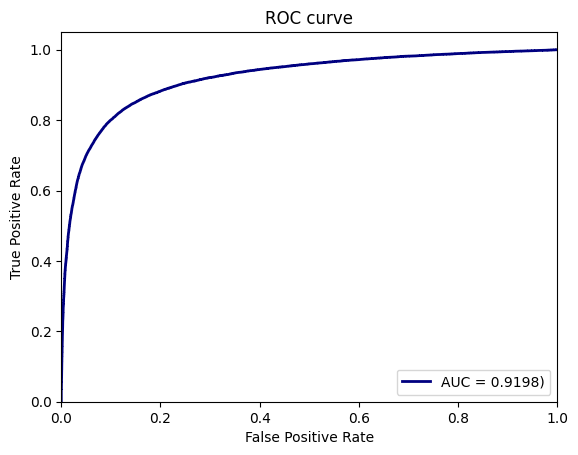

In [10]:
plt.figure()
plt.step(fpr, tpr,color='navy',linewidth=2,label='AUC = {0:.4f})'.format(testauc))
#plt.plot([0, 0], [1, 1], color='navy',linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc=4)
#plt.savefig("auc_curve.jpg")

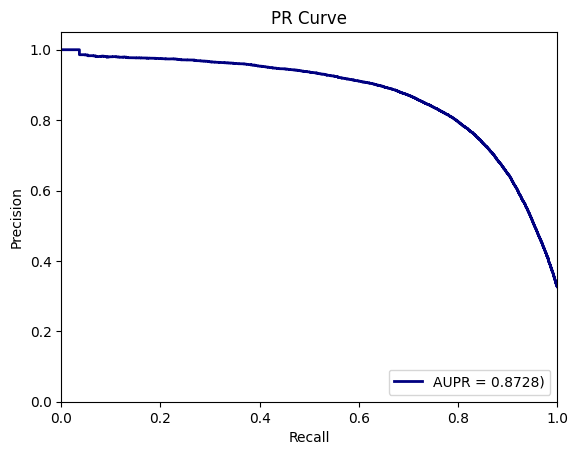

In [11]:
plt.figure()
plt.step(recall,precision,color='navy',linewidth=2,label='AUPR = {0:.4f})'.format(testaupr))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('PR Curve')
plt.legend(loc=4)
#plt.savefig("pr_curve.jpg")

In [16]:
with open('./results/hnuResults/RGCN_BiLSTM/RGCN_BiLSTMResult_gpu_directDot.pkl','rb') as f:  # Python 3: open(..., 'rb')
        trainloss, trainauc,trainaupr,valloss,valauc,valaupr,lrchange = pickle.load(f)

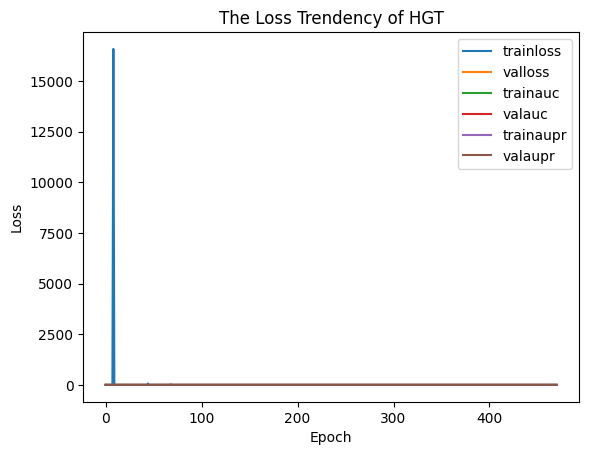

In [17]:
#plt.plot(trainloss)
plt.figure()
plt.plot(trainloss,label='trainloss')
plt.plot(valloss,label='valloss')
plt.plot(trainauc,label='trainauc')
plt.plot(valauc,label='valauc')
plt.plot(trainaupr,label='trainaupr')
plt.plot(valaupr,label='valaupr')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('The Loss Trendency of HGT')
plt.legend(loc=1)

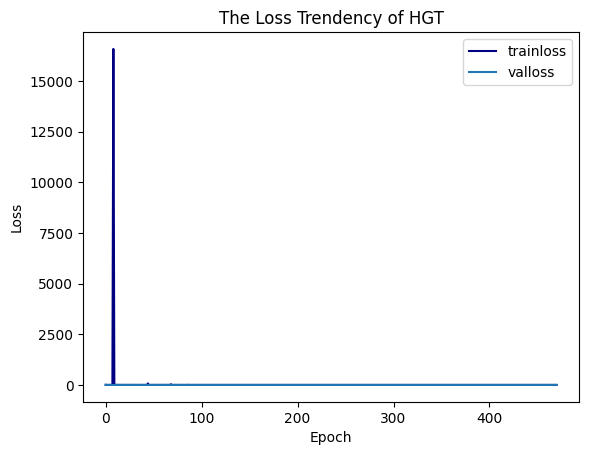

In [18]:
#plt.plot(trainloss)
plt.figure()
plt.plot(trainloss,label='trainloss',color='navy')
plt.plot(valloss,label='valloss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('The Loss Trendency of HGT')
plt.legend(loc=1)

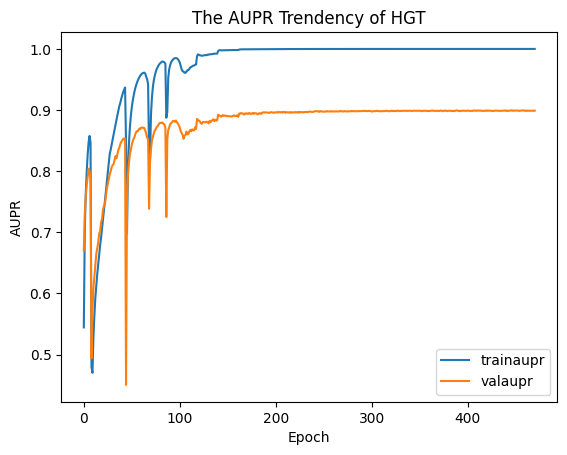

In [19]:
#plt.plot(trainloss)
plt.figure()
plt.plot(trainaupr,label='trainaupr')
plt.plot(valaupr,label='valaupr')
plt.xlabel('Epoch')
plt.ylabel('AUPR')
#plt.ylim([0.5, 0.71])
plt.title('The AUPR Trendency of HGT')
plt.legend(loc=4)

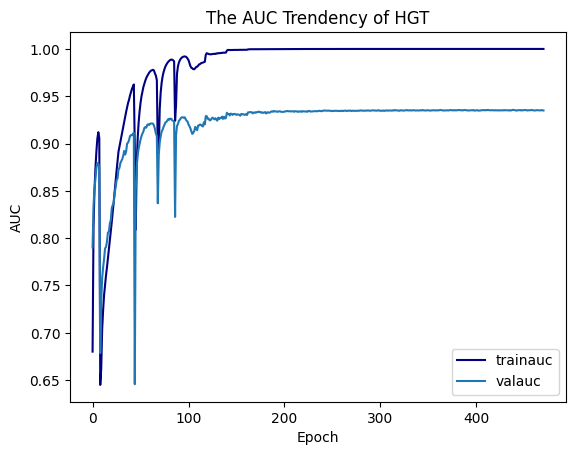

In [20]:
#plt.plot(trainloss)
plt.figure()
plt.plot(trainauc,label='trainauc',color='navy')
plt.plot(valauc,label='valauc')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('The AUC Trendency of HGT')
plt.legend(loc=4)

In [43]:
for name,parameters in model.named_parameters():
    print(name,':',parameters.size())

rgcn.conv1.weight : torch.Size([10, 1024, 256])
rgcn.conv1.comp : torch.Size([4, 10])
rgcn.conv1.root : torch.Size([1024, 256])
rgcn.conv1.bias : torch.Size([256])
rgcn.conv2.weight : torch.Size([10, 256, 128])
rgcn.conv2.comp : torch.Size([4, 10])
rgcn.conv2.root : torch.Size([256, 128])
rgcn.conv2.bias : torch.Size([128])
rgcn.lins.0.weight : torch.Size([1024, 279])
rgcn.lins.0.bias : torch.Size([1024])
rgcn.lins.1.weight : torch.Size([1024, 14676])
rgcn.lins.1.bias : torch.Size([1024])
bilstm.rnn.weight_ih_l0 : torch.Size([256, 100])
bilstm.rnn.weight_hh_l0 : torch.Size([256, 64])
bilstm.rnn.bias_ih_l0 : torch.Size([256])
bilstm.rnn.bias_hh_l0 : torch.Size([256])
bilstm.rnn.weight_ih_l0_reverse : torch.Size([256, 100])
bilstm.rnn.weight_hh_l0_reverse : torch.Size([256, 64])
bilstm.rnn.bias_ih_l0_reverse : torch.Size([256])
bilstm.rnn.bias_hh_l0_reverse : torch.Size([256])
bilstm.rnn.weight_ih_l1 : torch.Size([256, 128])
bilstm.rnn.weight_hh_l1 : torch.Size([256, 64])
bilstm.rnn.bias

In [45]:
#torch.save(HGT.state_dict(),'HGT6_00newall_1BiLinear_new.pth')
# torch.save(HGT.state_dict(),'HGT_00newall_BiLinear.pth')
torch.save(model.state_dict(),'RGCN_BiLSTM.pth')